Dataset shape: (539383, 9)
   id Airline  Flight AirportFrom AirportTo  DayOfWeek  Time  Length  Delay
0   1      CO     269         SFO       IAH          3    15     205      1
1   2      US    1558         PHX       CLT          3    15     222      1
2   3      AA    2400         LAX       DFW          3    20     165      1
3   4      AA    2466         SFO       DFW          3    20     195      1
4   5      AS     108         ANC       SEA          3    30     202      0

Missing values:
 id             0
Airline        0
Flight         0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Time           0
Length         0
Delay          0
dtype: int64

Data after preprocessing:
    Airline  Flight  AirportFrom  AirportTo  DayOfWeek  Time    Length  Delay  \
0        4     269          253        135          2    15  1.038237      1   
1       14    1558          217         60          2    15  1.280689      1   
2        1    2400          154         80          2    20  0.46

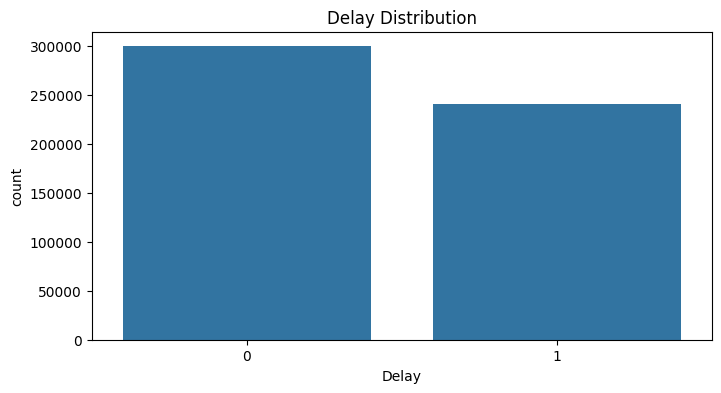

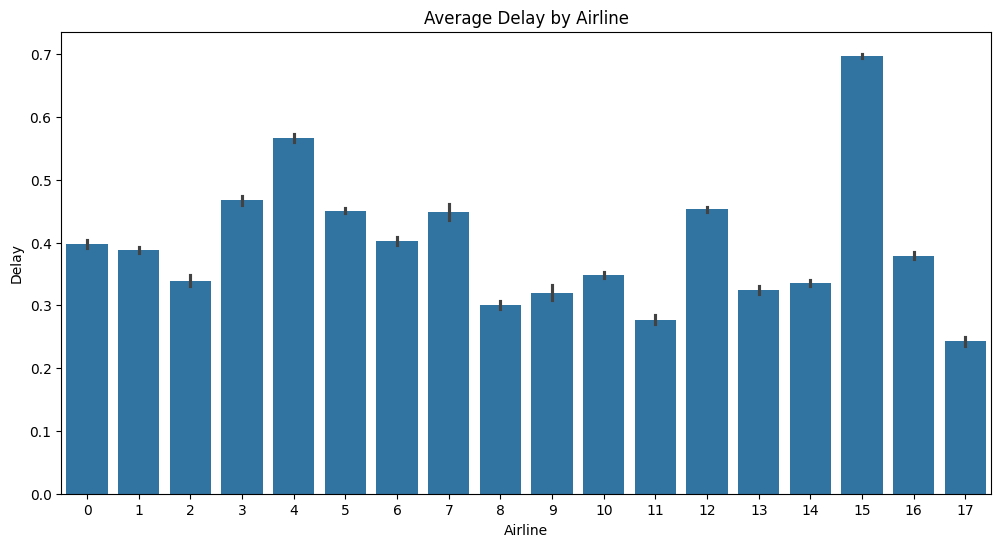

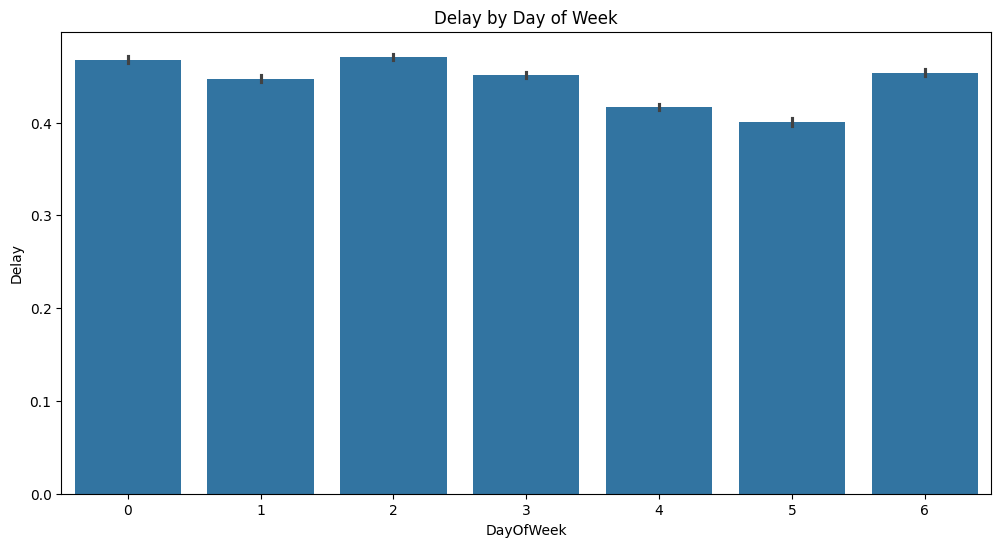


Train size: (431506, 10)  Test size: (107877, 10)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression:
Accuracy: 0.5851293602899599
ROC-AUC: 0.6077816660430888
              precision    recall  f1-score   support

           0       0.60      0.76      0.67     59824
           1       0.55      0.36      0.44     48053

    accuracy                           0.59    107877
   macro avg       0.58      0.56      0.55    107877
weighted avg       0.58      0.59      0.57    107877


Random Forest:
Accuracy: 0.616943370690694
ROC-AUC: 0.657650137320794
              precision    recall  f1-score   support

           0       0.65      0.67      0.66     59824
           1       0.57      0.55      0.56     48053

    accuracy                           0.62    107877
   macro avg       0.61      0.61      0.61    107877
weighted avg       0.62      0.62      0.62    107877



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:35:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost:
Accuracy: 0.6673155538251898
ROC-AUC: 0.7186069813345808
              precision    recall  f1-score   support

           0       0.67      0.80      0.73     59824
           1       0.67      0.50      0.57     48053

    accuracy                           0.67    107877
   macro avg       0.67      0.65      0.65    107877
weighted avg       0.67      0.67      0.66    107877



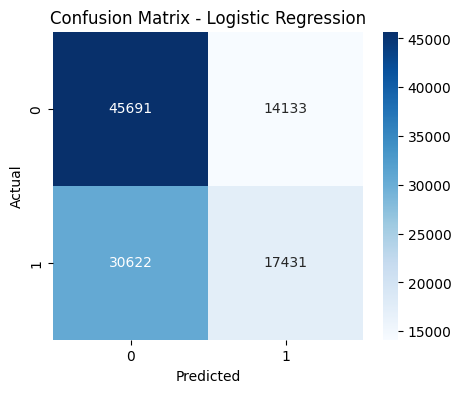

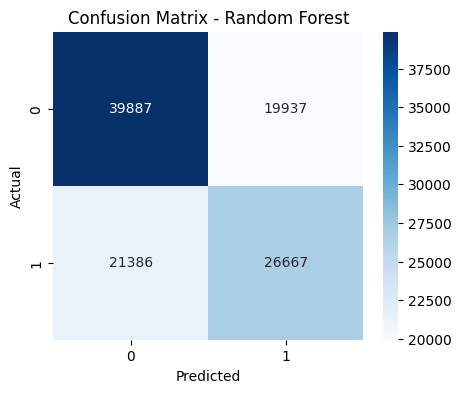

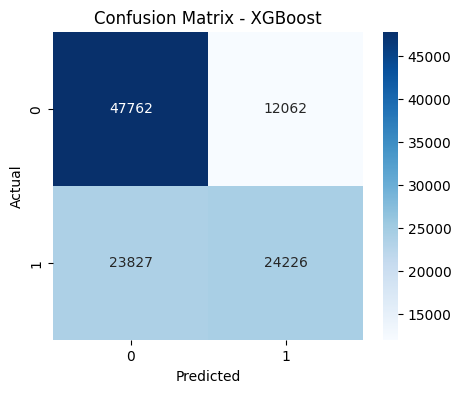

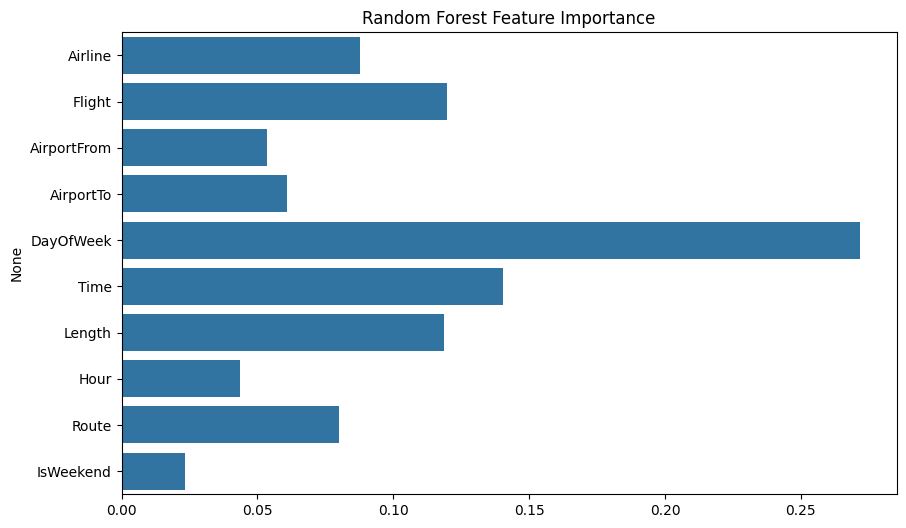

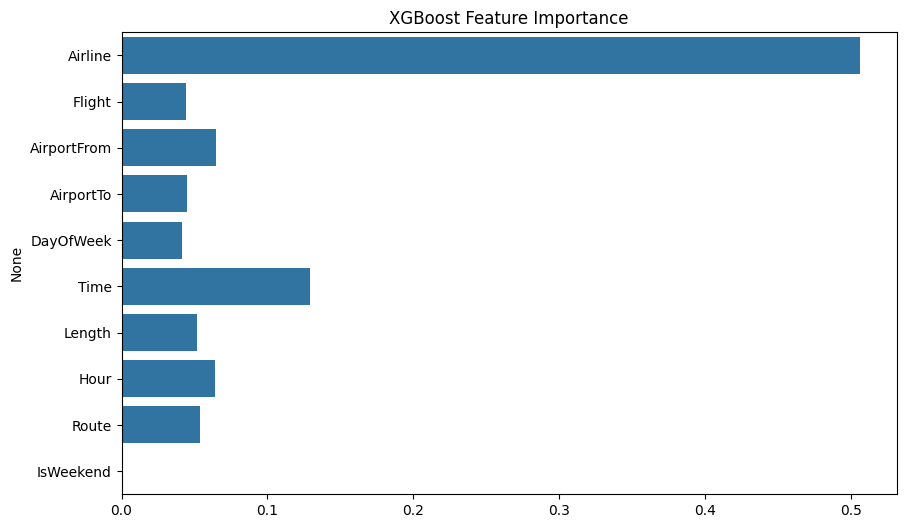

In [ ]:
# =========================================================
# Aircraft Flight Delay Prediction - Full Pipeline
# =========================================================

# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# =========================================================
# 2. Load Dataset
# =========================================================
df = pd.read_csv("Airlines.csv")
print("Dataset shape:", df.shape)
print(df.head())

# =========================================================
# 3. Data Cleaning & Preprocessing
# =========================================================

# Check missing values
print("\nMissing values:\n", df.isnull().sum())

# Drop 'id' column (not useful)
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True)

# Convert categorical features
cat_cols = ['Airline', 'AirportFrom', 'AirportTo', 'DayOfWeek']

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Convert 'Time' into hour of day
df['Hour'] = (df['Time'] // 100).astype(int)

# Feature scaling for numeric columns
scaler = StandardScaler()
df[['Length', 'Hour']] = scaler.fit_transform(df[['Length', 'Hour']])

print("\nData after preprocessing:\n", df.head())

# =========================================================
# 4. Exploratory Data Analysis (EDA)
# =========================================================
plt.figure(figsize=(8,4))
sns.countplot(x="Delay", data=df)
plt.title("Delay Distribution")
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(x="Airline", y="Delay", data=df)
plt.title("Average Delay by Airline")
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(x="DayOfWeek", y="Delay", data=df)
plt.title("Delay by Day of Week")
plt.show()

# =========================================================
# 5. Feature Engineering
# =========================================================
# Create Route feature
df['Route'] = df['AirportFrom'].astype(str) + "_" + df['AirportTo'].astype(str)
df['Route'] = LabelEncoder().fit_transform(df['Route'])

# Weekend flag
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x in [5,6] else 0)

# Define Features (X) and Target (y)
X = df.drop(columns=['Delay'])
y = df['Delay']

# =========================================================
# 6. Train-Test Split
# =========================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\nTrain size:", X_train.shape, " Test size:", X_test.shape)

# =========================================================
# 7. Modeling
# =========================================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    results[name] = {"Accuracy": acc, "ROC-AUC": roc}
    print(f"\n{name}:")
    print("Accuracy:", acc)
    print("ROC-AUC:", roc)
    print(classification_report(y_test, y_pred))

# =========================================================
# 8. Confusion Matrix Visualization
# =========================================================
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# =========================================================
# 9. Feature Importance (for tree models)
# =========================================================
rf_model = models["Random Forest"]
importances = rf_model.feature_importances_
feat_names = X.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=feat_names)
plt.title("Random Forest Feature Importance")
plt.show()

xgb_model = models["XGBoost"]
xgb_importances = xgb_model.feature_importances_

plt.figure(figsize=(10,6))
sns.barplot(x=xgb_importances, y=feat_names)
plt.title("XGBoost Feature Importance")
plt.show()

# =========================================================
# End of Project
# =========================================================
